In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson 
from statsmodels.regression.linear_model import OLS 
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [4]:
data=pd.read_csv('/kaggle/input/demand/data.csv')

In [5]:
data.head()

id  week  center_id  meal_id  checkout_price  base_price  \
0  1379560     1         55     1885          136.83      152.29   
1  1466964     1         55     1993          136.83      135.83   
2  1346989     1         55     2539          134.86      135.86   
3  1338232     1         55     2139          339.50      437.53   
4  1448490     1         55     2631          243.50      242.50   

   emailer_for_promotion  homepage_featured  num_orders  
0                      0                  0         177  
1                      0                  0         270  
2                      0                  0         189  
3                      0                  0          54  
4                      0                  0          40

***Filtering on id, center id, and meal id we have seen this three columns constitute primary key for the data table. And there are 5 more important columns and week number column which adds time dimension in the data making it a time series problem, and ultimately we have to make prediction for future weeks, for which data is not given.***

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     456548 non-null  int64  
 1   week                   456548 non-null  int64  
 2   center_id              456548 non-null  int64  
 3   meal_id                456548 non-null  int64  
 4   checkout_price         456548 non-null  float64
 5   base_price             456548 non-null  float64
 6   emailer_for_promotion  456548 non-null  int64  
 7   homepage_featured      456548 non-null  int64  
 8   num_orders             456548 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 31.3 MB


In [7]:
data.week.value_counts()

122    3359
105    3348
106    3347
140    3332
123    3331
       ... 
13     2838
12     2831
14     2830
7      2795
8      2786
Name: week, Length: 145, dtype: int64

*There are 145 week data given..*

In [8]:
data.center_id.value_counts()

13     7046
10     7015
52     6993
43     6970
67     6915
       ... 
139    4627
57     4501
162    4366
41     4083
91     3432
Name: center_id, Length: 77, dtype: int64

In [9]:
data.meal_id.value_counts()

2290    11138
1062    11137
1727    11136
1109    11134
1754    11132
2707    11123
1778    11121
1993    11116
1962    11114
1971    11102
1885    11092
2581    11072
2826    11057
2322    11002
1558    10952
1207    10806
2640    10747
1230    10746
1878    10527
2631    10458
2539    10451
1543    10236
2760    10209
1248     9939
2664     9853
2704     9811
1445     9727
2126     9705
1216     9695
2304     9676
2569     9459
2492     9382
1525     9359
2490     9247
2444     9097
2139     8899
2577     8667
2306     8294
2867     8092
1247     7184
1902     6748
1770     6682
1311     4682
1803     4674
1571     4511
1438     4385
1198     4206
2494     4206
1847     4084
2956     3319
2104     2357
Name: meal_id, dtype: int64

In [10]:
data.checkout_price.describe()

count    456548.000000
mean        332.238933
std         152.939723
min           2.970000
25%         228.950000
50%         296.820000
75%         445.230000
max         866.270000
Name: checkout_price, dtype: float64

Ratio of mean and sd is nearly 2, so the spread is not very large, laso minimum checkout price 2.97 could be a potential outlier.

In [11]:
data.base_price.describe()

count    456548.000000
mean        354.156627
std         160.715914
min          55.350000
25%         243.500000
50%         310.460000
75%         458.870000
max         866.270000
Name: base_price, dtype: float64

In [12]:
data.sort_values('checkout_price').head()

id  week  center_id  meal_id  checkout_price  base_price  \
110286  1300283    38         73     1230            2.97      316.25   
44875   1381921    16         41     1248           45.62      253.23   
44874   1414392    16         41     2631           47.59      253.23   
417180  1372230   134         24     2631           53.41       86.39   
72701   1324508    26        124     1803           55.35      212.43   

        emailer_for_promotion  homepage_featured  num_orders  
110286                      0                  0          14  
44875                       0                  0         123  
44874                       0                  0         163  
417180                      1                  0         134  
72701                       0                  0          81

In [13]:
data.num_orders.describe()

count    456548.000000
mean        261.872760
std         395.922798
min          13.000000
25%          54.000000
50%         136.000000
75%         324.000000
max       24299.000000
Name: num_orders, dtype: float64

In [14]:
data.sort_values('num_orders').tail()

id  week  center_id  meal_id  checkout_price  base_price  \
413351  1346216   132         43     1971          204.70      324.04   
13923   1470267     5         10     2290          162.99      309.43   
16904   1087163     6         43     2290          156.20      310.43   
19700   1300512     7         43     2290          159.08      311.43   
14050   1452474     5         43     2290          159.08      311.43   

        emailer_for_promotion  homepage_featured  num_orders  
413351                      1                  1       13150  
13923                       1                  0       13580  
16904                       0                  1       14229  
19700                       1                  1       15336  
14050                       1                  1       24299

In [15]:
data.emailer_for_promotion.value_counts()

0    419498
1     37050
Name: emailer_for_promotion, dtype: int64

In [16]:
data.homepage_featured.value_counts()

0    406693
1     49855
Name: homepage_featured, dtype: int64

The ratio between promotion and hoepage featured is nearly same let's see how many of them matched.

In [17]:
sum(abs(data['emailer_for_promotion']-data['homepage_featured'])/456548)

0.10610713440869829

Not many of them matched, which implies there are a lot of vendors which has their ad homepage featured but not emailed for promotion and vice versa.

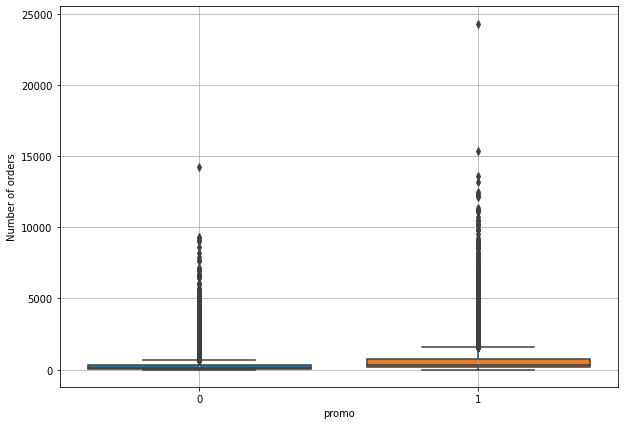

In [18]:
plt.figure(figsize=(10,7))
sns.boxplot(x='emailer_for_promotion',y='num_orders',data=data)
plt.grid()
plt.xlabel("promo")
plt.ylabel("Number of orders")
plt.show()

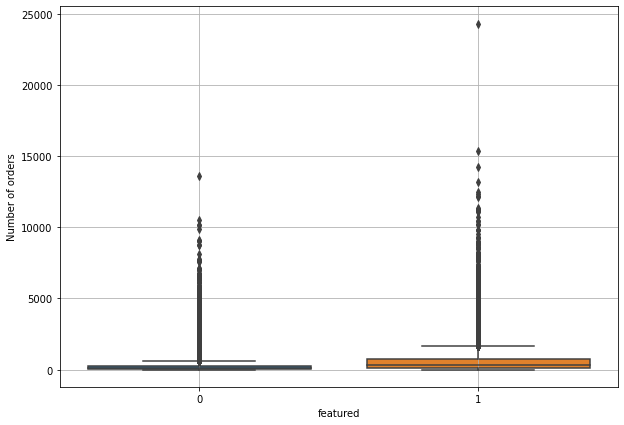

In [19]:
plt.figure(figsize=(10,7))
sns.boxplot(x='homepage_featured',y='num_orders',data=data)
plt.grid()
plt.xlabel("featured")
plt.ylabel("Number of orders")
plt.show()

Homepage featured and promotion has more high volumn orders, it can be said they have some effect on number of orders

In [20]:
fs=pd.read_csv('/kaggle/input/demand/fulfilment_center_info.csv')

In [21]:
fs.head()

center_id  city_code  region_code center_type  op_area
0         11        679           56      TYPE_A      3.7
1         13        590           56      TYPE_B      6.7
2        124        590           56      TYPE_C      4.0
3         66        648           34      TYPE_A      4.1
4         94        632           34      TYPE_C      3.6

This is the fulfillment center data, which are basically meal warehouses.

In [22]:
fs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   center_id    77 non-null     int64  
 1   city_code    77 non-null     int64  
 2   region_code  77 non-null     int64  
 3   center_type  77 non-null     object 
 4   op_area      77 non-null     float64
dtypes: float64(1), int64(3), object(1)
memory usage: 3.1+ KB


In [23]:
fs.city_code.value_counts()

590    9
526    8
638    3
647    2
614    2
676    2
604    2
522    2
576    2
699    2
593    2
517    2
651    1
456    1
695    1
602    1
700    1
703    1
679    1
485    1
685    1
577    1
461    1
702    1
615    1
599    1
579    1
609    1
658    1
683    1
675    1
541    1
659    1
648    1
632    1
553    1
693    1
562    1
478    1
713    1
654    1
515    1
698    1
628    1
680    1
620    1
649    1
596    1
473    1
556    1
561    1
Name: city_code, dtype: int64

In [24]:
fs.region_code.value_counts()

56    30
34    21
77    17
85     5
23     1
71     1
35     1
93     1
Name: region_code, dtype: int64

Region 56,34,77 are more repeatedly occurring.

In [25]:
fs.center_type.value_counts()

TYPE_A    43
TYPE_C    19
TYPE_B    15
Name: center_type, dtype: int64

more center,city, region combinations has center type A

In [26]:
fs.op_area.describe()

count    77.000000
mean      3.985714
std       1.106406
min       0.900000
25%       3.500000
50%       3.900000
75%       4.400000
max       7.000000
Name: op_area, dtype: float64

In [27]:
mi=pd.read_csv('/kaggle/input/demand/meal_info.csv')

In [28]:
mi.head()

meal_id   category cuisine
0     1885  Beverages    Thai
1     1993  Beverages    Thai
2     2539  Beverages    Thai
3     1248  Beverages  Indian
4     2631  Beverages  Indian

Preceding is the meal id data, which contains meal id, meal catagory and cuisine type columns.

In [29]:
mi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   meal_id   51 non-null     int64 
 1   category  51 non-null     object
 2   cuisine   51 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.3+ KB


In [30]:
mi.category.value_counts()

Beverages       12
Extras           3
Soup             3
Other Snacks     3
Salad            3
Rice Bowl        3
Starters         3
Sandwich         3
Pasta            3
Desert           3
Biryani          3
Pizza            3
Fish             3
Seafood          3
Name: category, dtype: int64

In [31]:
mi.cuisine.value_counts()

Thai           15
Indian         12
Italian        12
Continental    12
Name: cuisine, dtype: int64

In [32]:
master_data=data.merge(fs,on='center_id',how='left').merge(mi,on='meal_id',how='left')

Joined the meal and fulfillment center data to the order data on left, so that no order row gets repeated.

In [33]:
master_data.head()

id  week  center_id  meal_id  checkout_price  base_price  \
0  1379560     1         55     1885          136.83      152.29   
1  1466964     1         55     1993          136.83      135.83   
2  1346989     1         55     2539          134.86      135.86   
3  1338232     1         55     2139          339.50      437.53   
4  1448490     1         55     2631          243.50      242.50   

   emailer_for_promotion  homepage_featured  num_orders  city_code  \
0                      0                  0         177        647   
1                      0                  0         270        647   
2                      0                  0         189        647   
3                      0                  0          54        647   
4                      0                  0          40        647   

   region_code center_type  op_area   category cuisine  
0           56      TYPE_C      2.0  Beverages    Thai  
1           56      TYPE_C      2.0  Beverages    Thai  
2           56      TYPE_C      2.0  Beverages    Thai  
3           56      TYPE_C      2.0  Beverages  Indian  
4           56      TYPE_C      2.0  Beverages  Indian

In [34]:
data.shape

(456548, 9)

In [35]:
master_data.shape

(456548, 15)

The final data has 6 more columns, as the fulfillment center had 5 columns and meal infor had 3 columns, and joined on the id column, a total of 4+2=6 additional columns were added to the master data.

In [36]:
master_data.isnull().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
city_code                0
region_code              0
center_type              0
op_area                  0
category                 0
cuisine                  0
dtype: int64

In [37]:
master_data.dtypes

id                         int64
week                       int64
center_id                  int64
meal_id                    int64
checkout_price           float64
base_price               float64
emailer_for_promotion      int64
homepage_featured          int64
num_orders                 int64
city_code                  int64
region_code                int64
center_type               object
op_area                  float64
category                  object
cuisine                   object
dtype: object

In [38]:
master_data.describe()

id           week      center_id        meal_id  \
count  4.565480e+05  456548.000000  456548.000000  456548.000000   
mean   1.250096e+06      74.768771      82.105796    2024.337458   
std    1.443548e+05      41.524956      45.975046     547.420920   
min    1.000000e+06       1.000000      10.000000    1062.000000   
25%    1.124999e+06      39.000000      43.000000    1558.000000   
50%    1.250184e+06      76.000000      76.000000    1993.000000   
75%    1.375140e+06     111.000000     110.000000    2539.000000   
max    1.499999e+06     145.000000     186.000000    2956.000000   

       checkout_price     base_price  emailer_for_promotion  \
count   456548.000000  456548.000000          456548.000000   
mean       332.238933     354.156627               0.081152   
std        152.939723     160.715914               0.273069   
min          2.970000      55.350000               0.000000   
25%        228.950000     243.500000               0.000000   
50%        296.820000     310.460000               0.000000   
75%        445.230000     458.870000               0.000000   
max        866.270000     866.270000               1.000000   

       homepage_featured     num_orders      city_code    region_code  \
count       456548.00000  456548.000000  456548.000000  456548.000000   
mean             0.10920     261.872760     601.553399      56.614566   
std              0.31189     395.922798      66.195914      17.641306   
min              0.00000      13.000000     456.000000      23.000000   
25%              0.00000      54.000000     553.000000      34.000000   
50%              0.00000     136.000000     596.000000      56.000000   
75%              0.00000     324.000000     651.000000      77.000000   
max              1.00000   24299.000000     713.000000      93.000000   

             op_area  
count  456548.000000  
mean        4.083590  
std         1.091686  
min         0.900000  
25%         3.600000  
50%         4.000000  
75%         4.500000  
max         7.000000

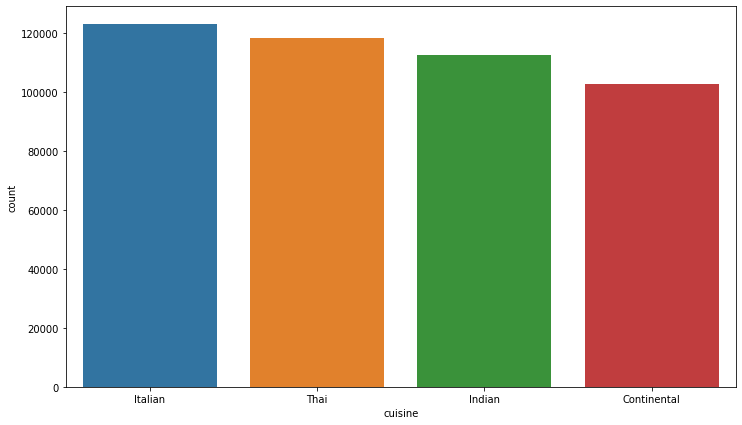

In [39]:
#print(mdd['cuisine'].value_counts())
plt.figure(figsize=(12,7))
sns.countplot(master_data['cuisine'],order=master_data['cuisine'].value_counts().index)
plt.show()

More variety of italian foods followed by thai indian continental

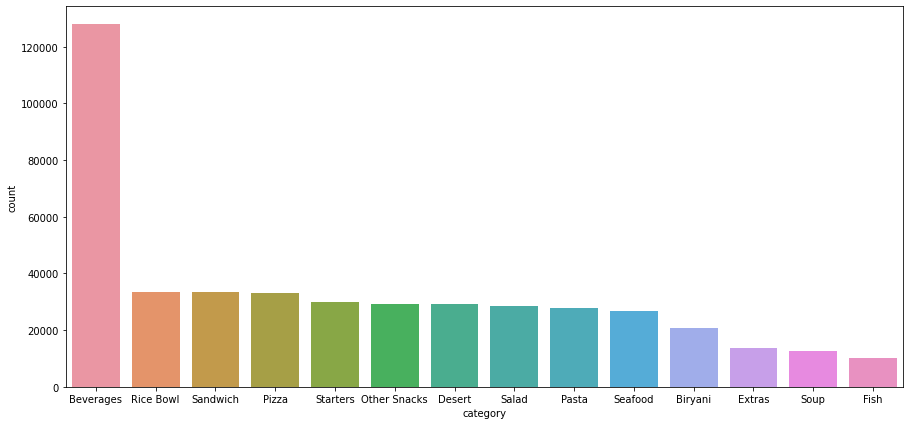

In [40]:
#print(mdd['category'].value_counts())
plt.figure(figsize=(15,7))
sns.countplot(master_data['category'],order=master_data['category'].value_counts().index)
plt.show()

More variety of beverages then rice bowl etc...


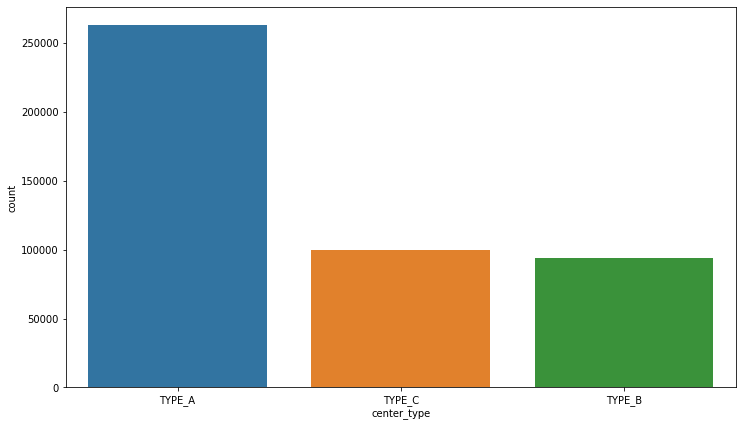

In [41]:
#print(mdd['center_type'].value_counts())
plt.figure(figsize=(12,7))
sns.countplot(master_data['center_type'],order=master_data['center_type'].value_counts().index)
plt.show()

........

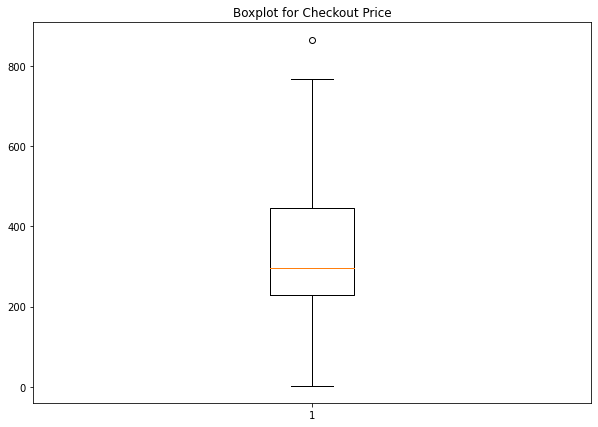

The following are outliers in the boxplot:
Series([], Name: checkout_price, dtype: float64)


In [42]:
data2=master_data['checkout_price']
fig,ax=plt.subplots(1,1,figsize=(10,7))
ax.boxplot(data2)
ax.set_title('Boxplot for Checkout Price')
plt.show()

q1=np.quantile(data2,0.25)
q3=np.quantile(data2,0.75)
med=np.median(data2)
iqr=q3-q1
ub=q3+(2*iqr)
lb=q1-(2*iqr)
outliers=data2[(data2<=lb)|(data2>=ub)]
print('The following are outliers in the boxplot:\n{}'.format(outliers))

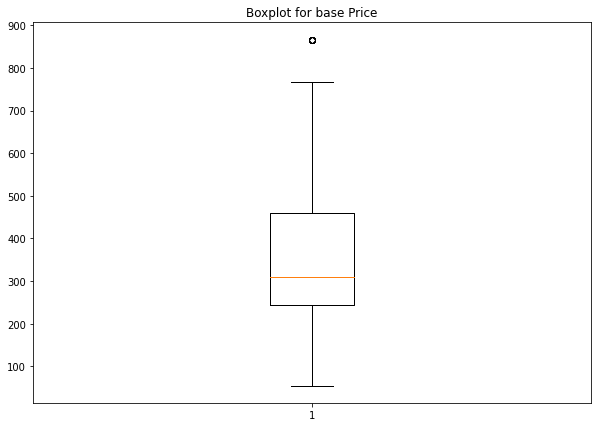

The following are outliers in the boxplot:
Series([], Name: base_price, dtype: float64)


In [43]:
data3=master_data['base_price']
fig,ax=plt.subplots(1,1,figsize=(10,7))
ax.boxplot(data3)
ax.set_title('Boxplot for base Price')
plt.show()

q1=np.quantile(data3,0.25)
q3=np.quantile(data3,0.75)
med=np.median(data3)
iqr=q3-q1
ub=q3+(2*iqr)
lb=q1-(2*iqr)
outliers=data3[(data3<=lb)|(data3>=ub)]
print('The following are outliers in the boxplot:\n{}'.format(outliers))

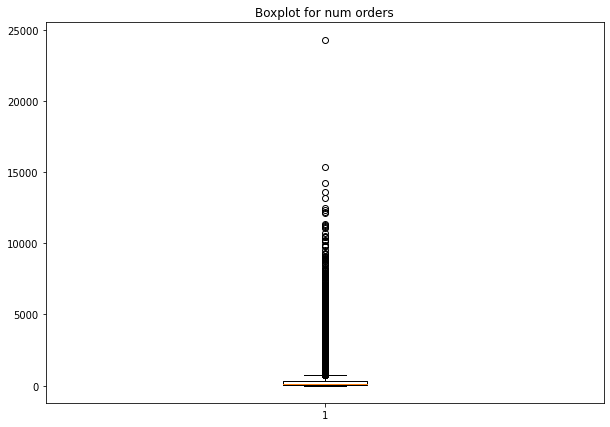

The following are outliers in the boxplot:
10         823
11         972
14         756
20         798
33        1498
          ... 
456457    1188
456465     755
456471     851
456482     850
456546     729
Name: num_orders, Length: 33301, dtype: int64


In [44]:
data4=master_data['num_orders']
fig,ax=plt.subplots(1,1,figsize=(10,7))
ax.boxplot(data4)
ax.set_title('Boxplot for num orders')
plt.show()

q1=np.quantile(data4,0.25)
q3=np.quantile(data4,0.75)
med=np.median(data4)
iqr=q3-q1
ub=q3+(1.5*iqr)
lb=q1-(1.5*iqr)
outliers=data4[(data4<=lb)|(data4>=ub)]
print('The following are outliers in the boxplot:\n{}'.format(outliers))

The Number of orders data is skewed you can say that 33301 observations have huge number of orders, rest has very few, an example of pareto (income) distribution

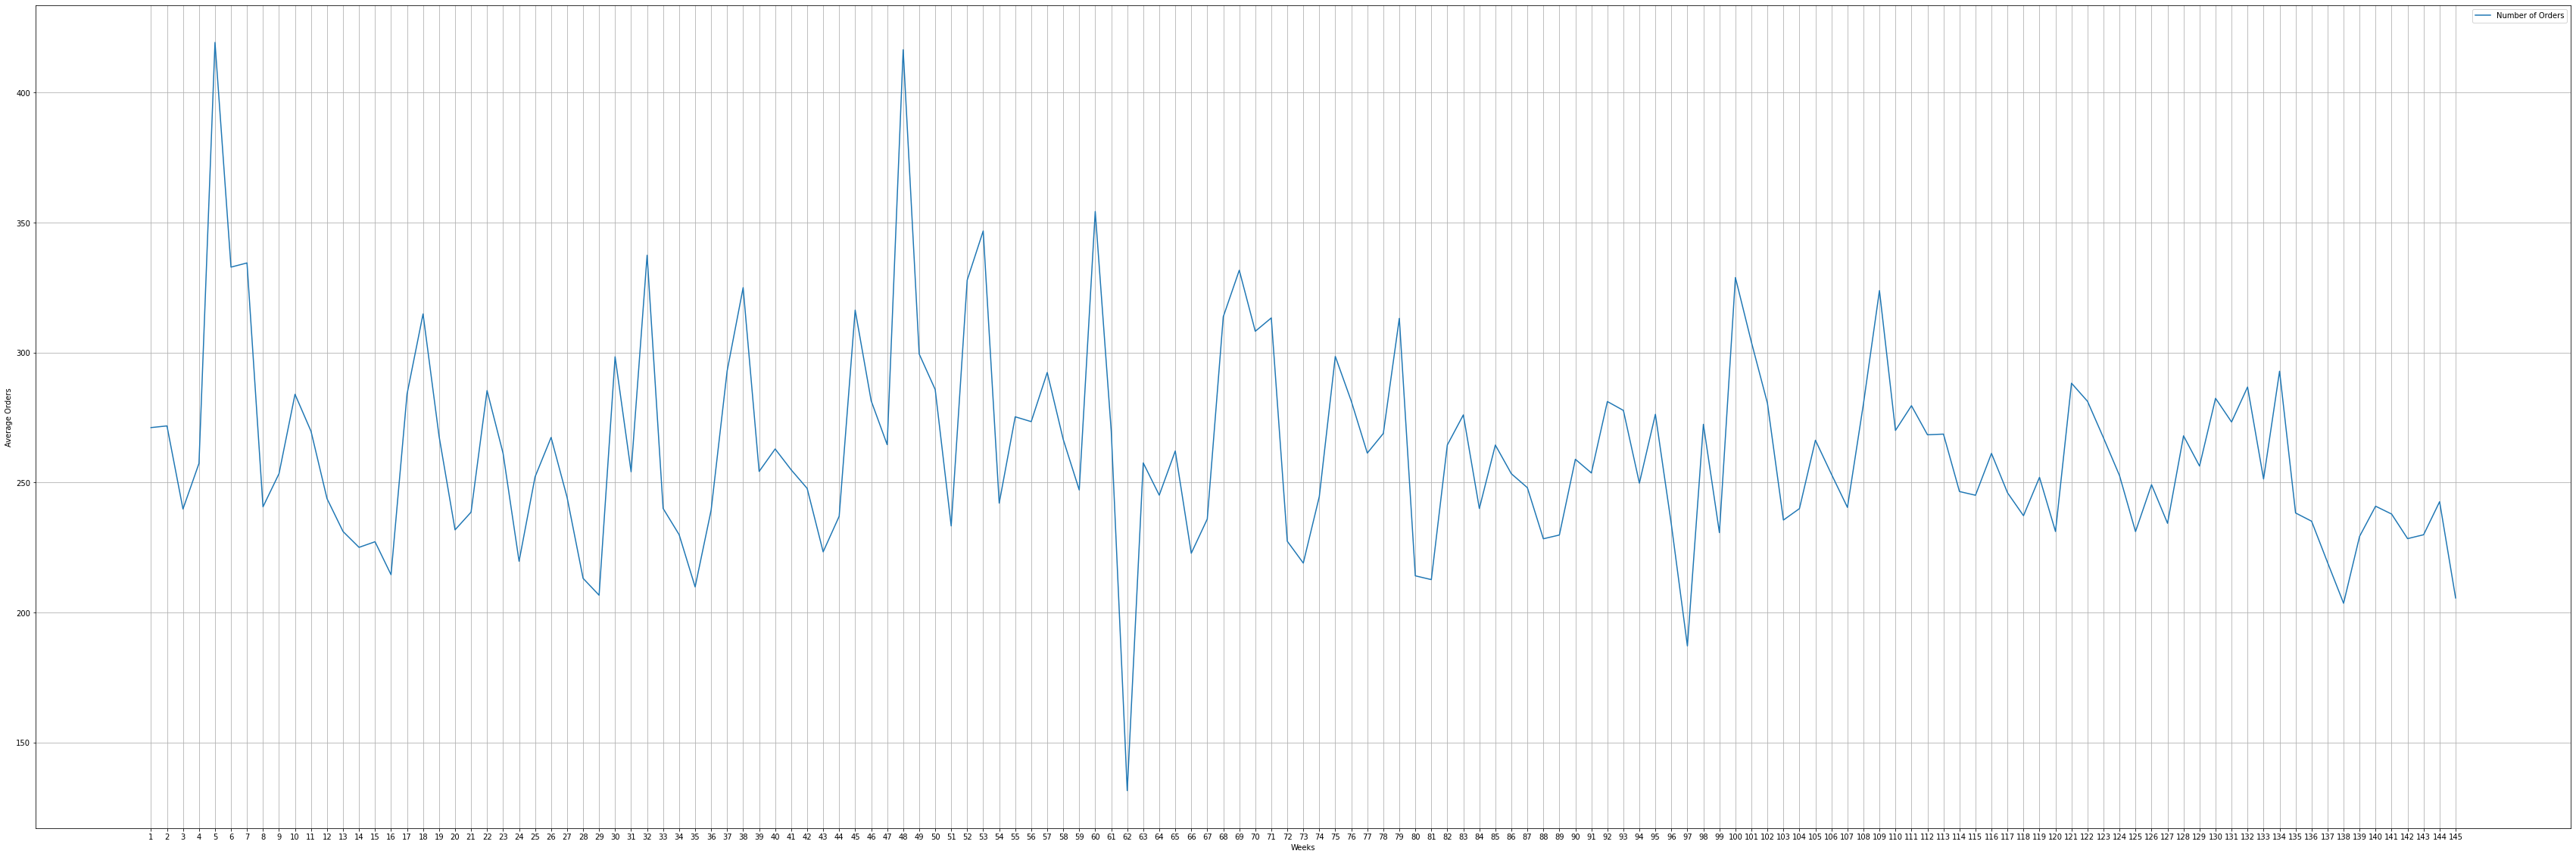

In [45]:
plt.figure(figsize=(60,20))
sns.lineplot(x='week',y='num_orders',data=master_data, label='Number of Orders',ci=None)
plt.grid()
plt.xlabel("Weeks")
plt.ylabel("Average Orders")
stick=np.arange(1,146,1)
plt.xticks(stick)
plt.show()

From the above can be seen, weeks 5 and 48 has a sharp peak and weeeks 62 has dips

In [46]:
md62 = master_data[master_data.week == 62]
md48 = master_data[master_data.week == 48]
md5  = master_data[master_data.week == 5]

In [47]:
md62.emailer_for_promotion.value_counts()

0    2715
1     175
Name: emailer_for_promotion, dtype: int64

In [48]:
md48.emailer_for_promotion.value_counts()

0    2729
1     401
Name: emailer_for_promotion, dtype: int64

In [49]:
md5.emailer_for_promotion.value_counts()

0    2522
1     337
Name: emailer_for_promotion, dtype: int64

In [50]:
md62.homepage_featured.value_counts()

0    2595
1     295
Name: homepage_featured, dtype: int64

In [51]:
md48.homepage_featured.value_counts()

0    2810
1     320
Name: homepage_featured, dtype: int64

In [52]:
md5.homepage_featured.value_counts()

0    2393
1     466
Name: homepage_featured, dtype: int64

As we can see there is not much difference in homepage featured of peak weeks 5,48 and dip week 62. Unlike emailer for promotion, so we can say that promotions have more effect in sales than homepage featured.

Text(0, 0.5, 'Number of orders')

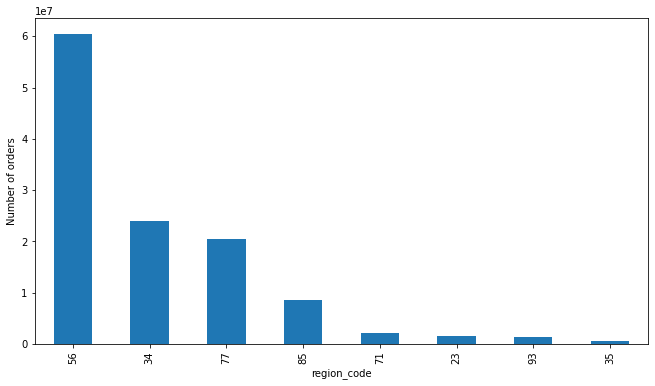

In [53]:
plt.figure(figsize=(11,6))
master_data.groupby(['region_code'])['num_orders'].sum().sort_values(ascending=False).plot.bar()
plt.ylabel('Number of orders')

Most number of orders from Region 56

Text(0, 0.5, 'Number of orders')

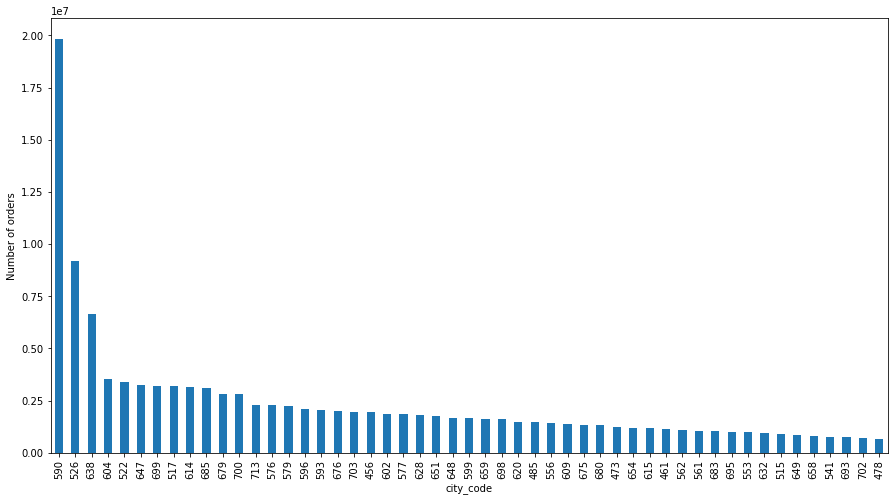

In [54]:
plt.figure(figsize=(15,8))
master_data.groupby(['city_code'])['num_orders'].sum().sort_values(ascending=False).plot.bar()
plt.ylabel('Number of orders')

Most orders from City 590

Text(0, 0.5, 'Number of orders')

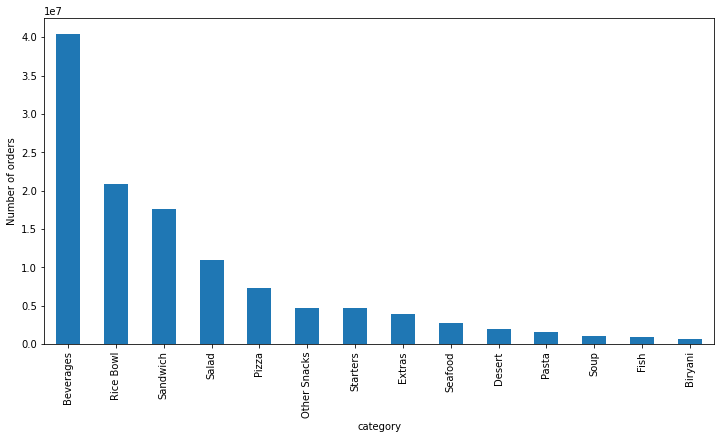

In [55]:
plt.figure(figsize=(12,6))
master_data.groupby(['category'])['num_orders'].sum().sort_values(ascending=False).plot.bar()
plt.ylabel('Number of orders')

Most orders are beverages

In [56]:
master_data['month'] = (((master_data['week'] - 1)/4).astype('int') % 13) + 1
master_data.month.value_counts()

8     38345
9     38278
10    38242
7     38040
5     37940
6     37724
1     37390
4     37270
3     37011
2     36849
11    28782
12    25418
13    25259
Name: month, dtype: int64

In [57]:
master_data['year'] = (((master_data['week'] - 1)/52) + 1).astype('int')
master_data.year.value_counts()

2    167029
1    154989
3    134530
Name: year, dtype: int64

In [58]:
master_data['week_in_month'] = (((master_data['week'] - 1) % 4) + 1)
master_data.week_in_month.value_counts()

1    116786
4    113452
2    113195
3    113115
Name: week_in_month, dtype: int64

Converted weeks to months, years and week no in months.

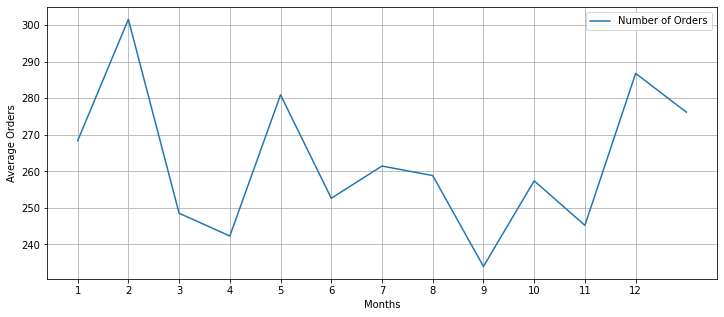

In [59]:
plt.figure(figsize=(12,5))
sns.lineplot(x='month',y='num_orders',data=master_data, label='Number of Orders',ci=None)
plt.grid()
plt.xlabel("Months")
plt.ylabel("Average Orders")
stick=np.arange(1,13,1)
plt.xticks(stick)
plt.show()

Peak in February and dip in september

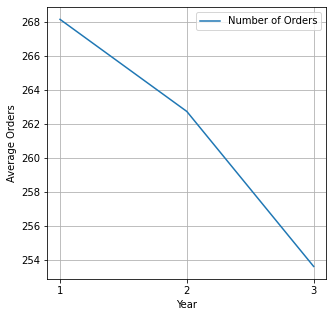

In [60]:
plt.figure(figsize=(5,5))
sns.lineplot(x='year',y='num_orders',data=master_data, label='Number of Orders',ci=None)
plt.grid()
plt.xlabel("Year")
plt.ylabel("Average Orders")
stick=np.arange(1,4,1)
plt.xticks(stick)
plt.show()

Overall downwards trend in total order

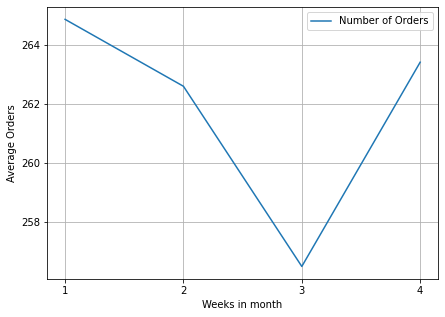

In [61]:
plt.figure(figsize=(7,5))
sns.lineplot(x='week_in_month',y='num_orders',data=master_data, label='Number of Orders',ci=None)
plt.grid()
plt.xlabel("Weeks in month")
plt.ylabel("Average Orders")
stick=np.arange(1,5,1)
plt.xticks(stick)
plt.show()

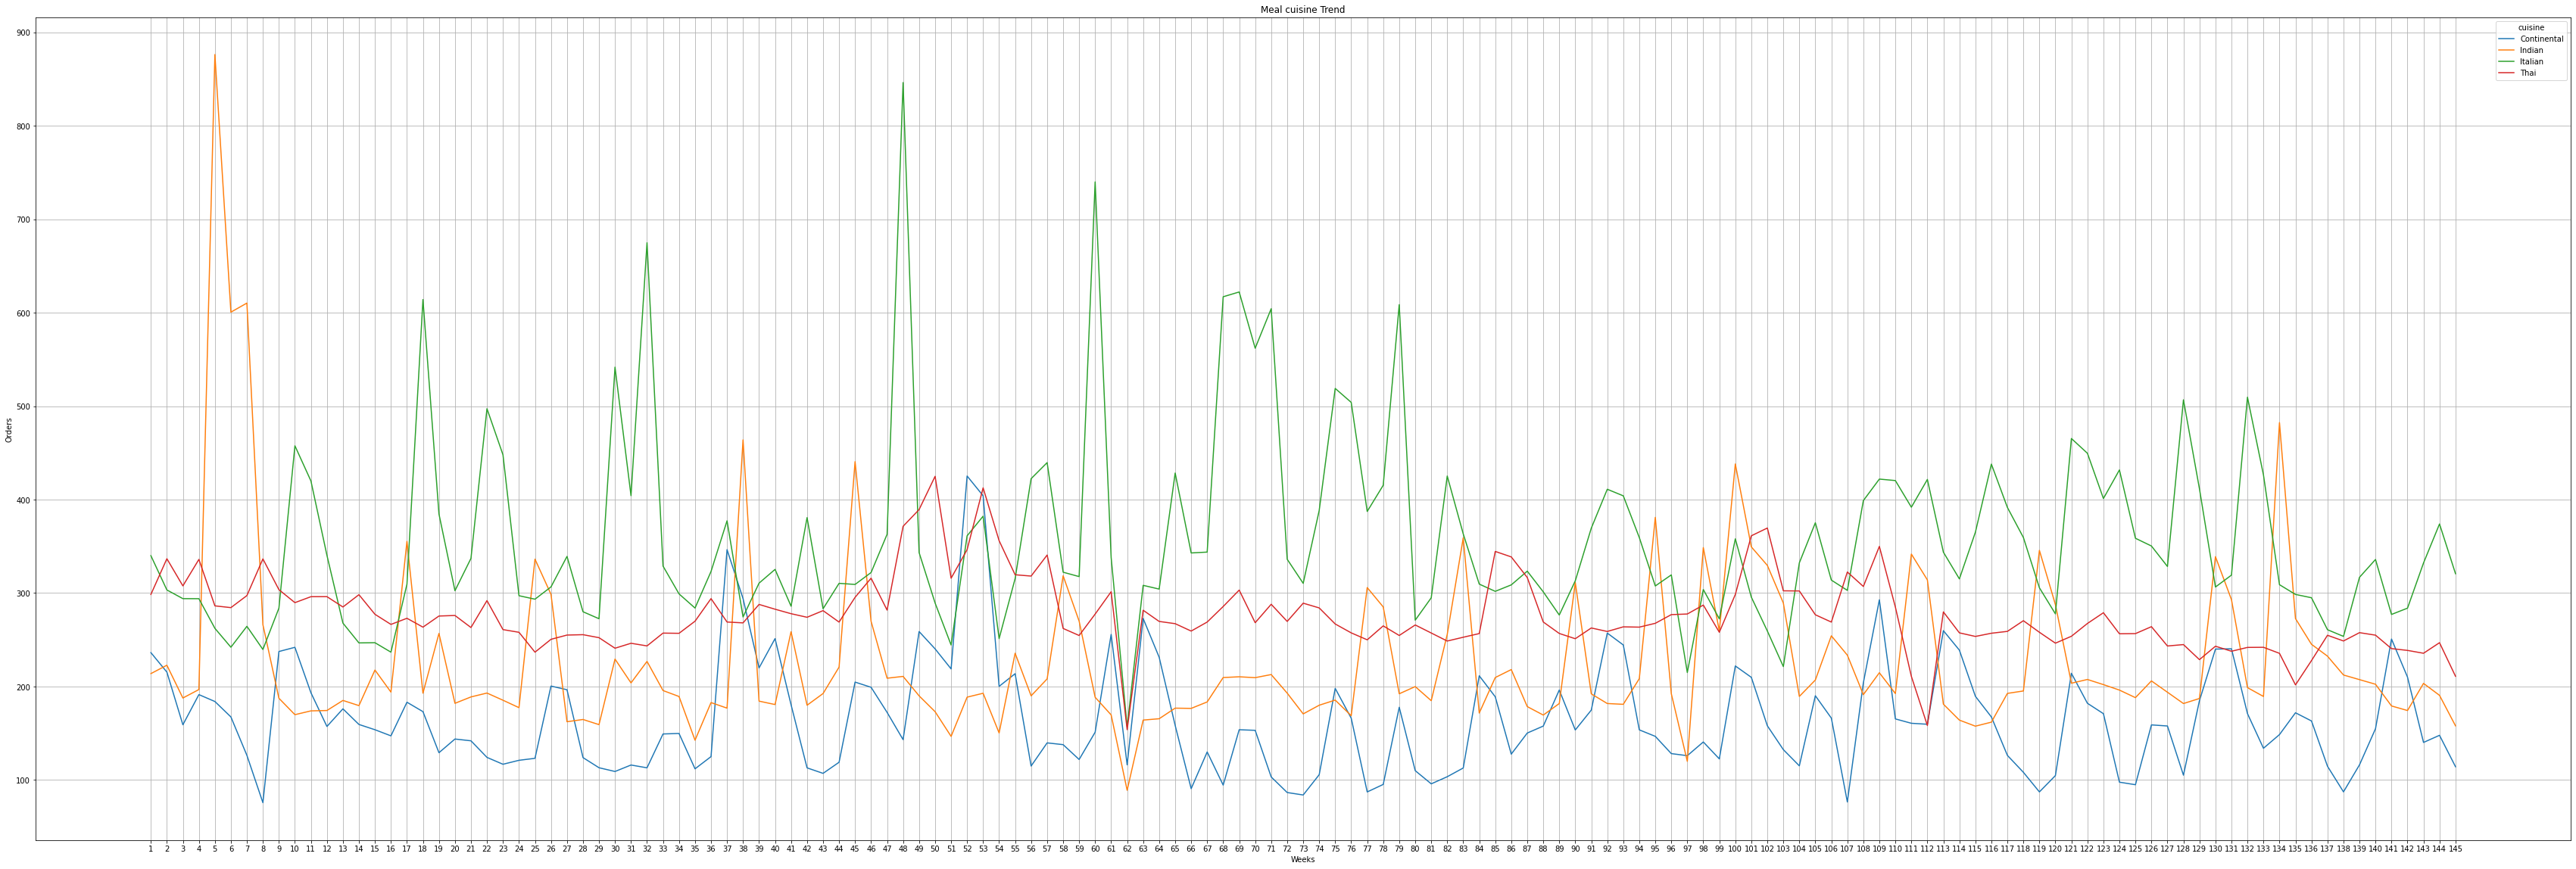

In [62]:
cuisine_trend = master_data.pivot_table(index='week', columns='cuisine', values='num_orders', aggfunc='mean')
cuisine_trend.plot(figsize=(60,20))
plt.grid()
stick=np.arange(1,146,1)
plt.xticks(stick)
plt.title("Meal cuisine Trend")
plt.xlabel("Weeks")
plt.ylabel("Orders")
plt.show()

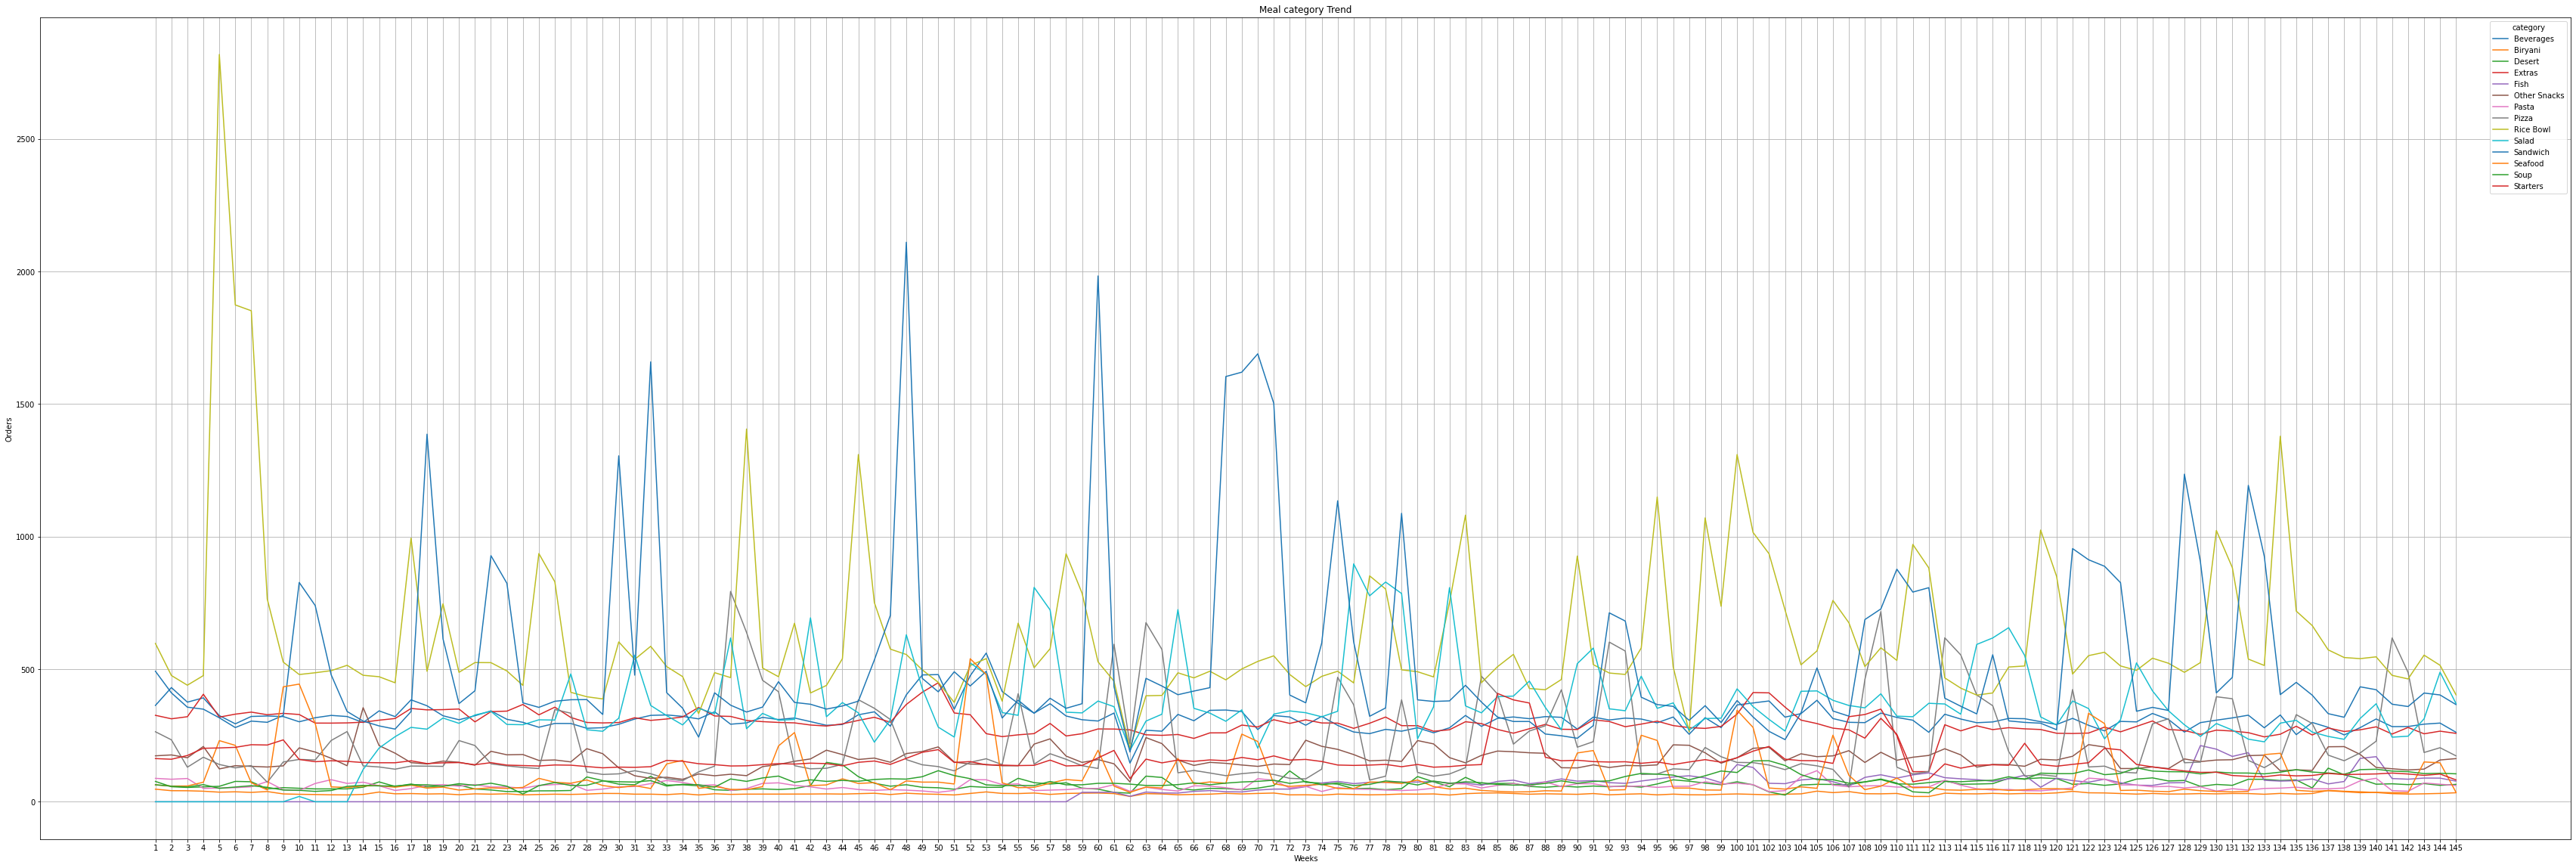

In [63]:
category_trend = master_data.pivot_table(index='week', columns='category', values='num_orders', aggfunc='mean')
category_trend = category_trend.fillna(0)
category_trend.plot(figsize=(60, 20))
plt.grid()
stick=np.arange(1,146,1)
plt.xticks(stick)
plt.title("Meal category Trend")
plt.xlabel("Weeks")
plt.ylabel("Orders")
plt.show()

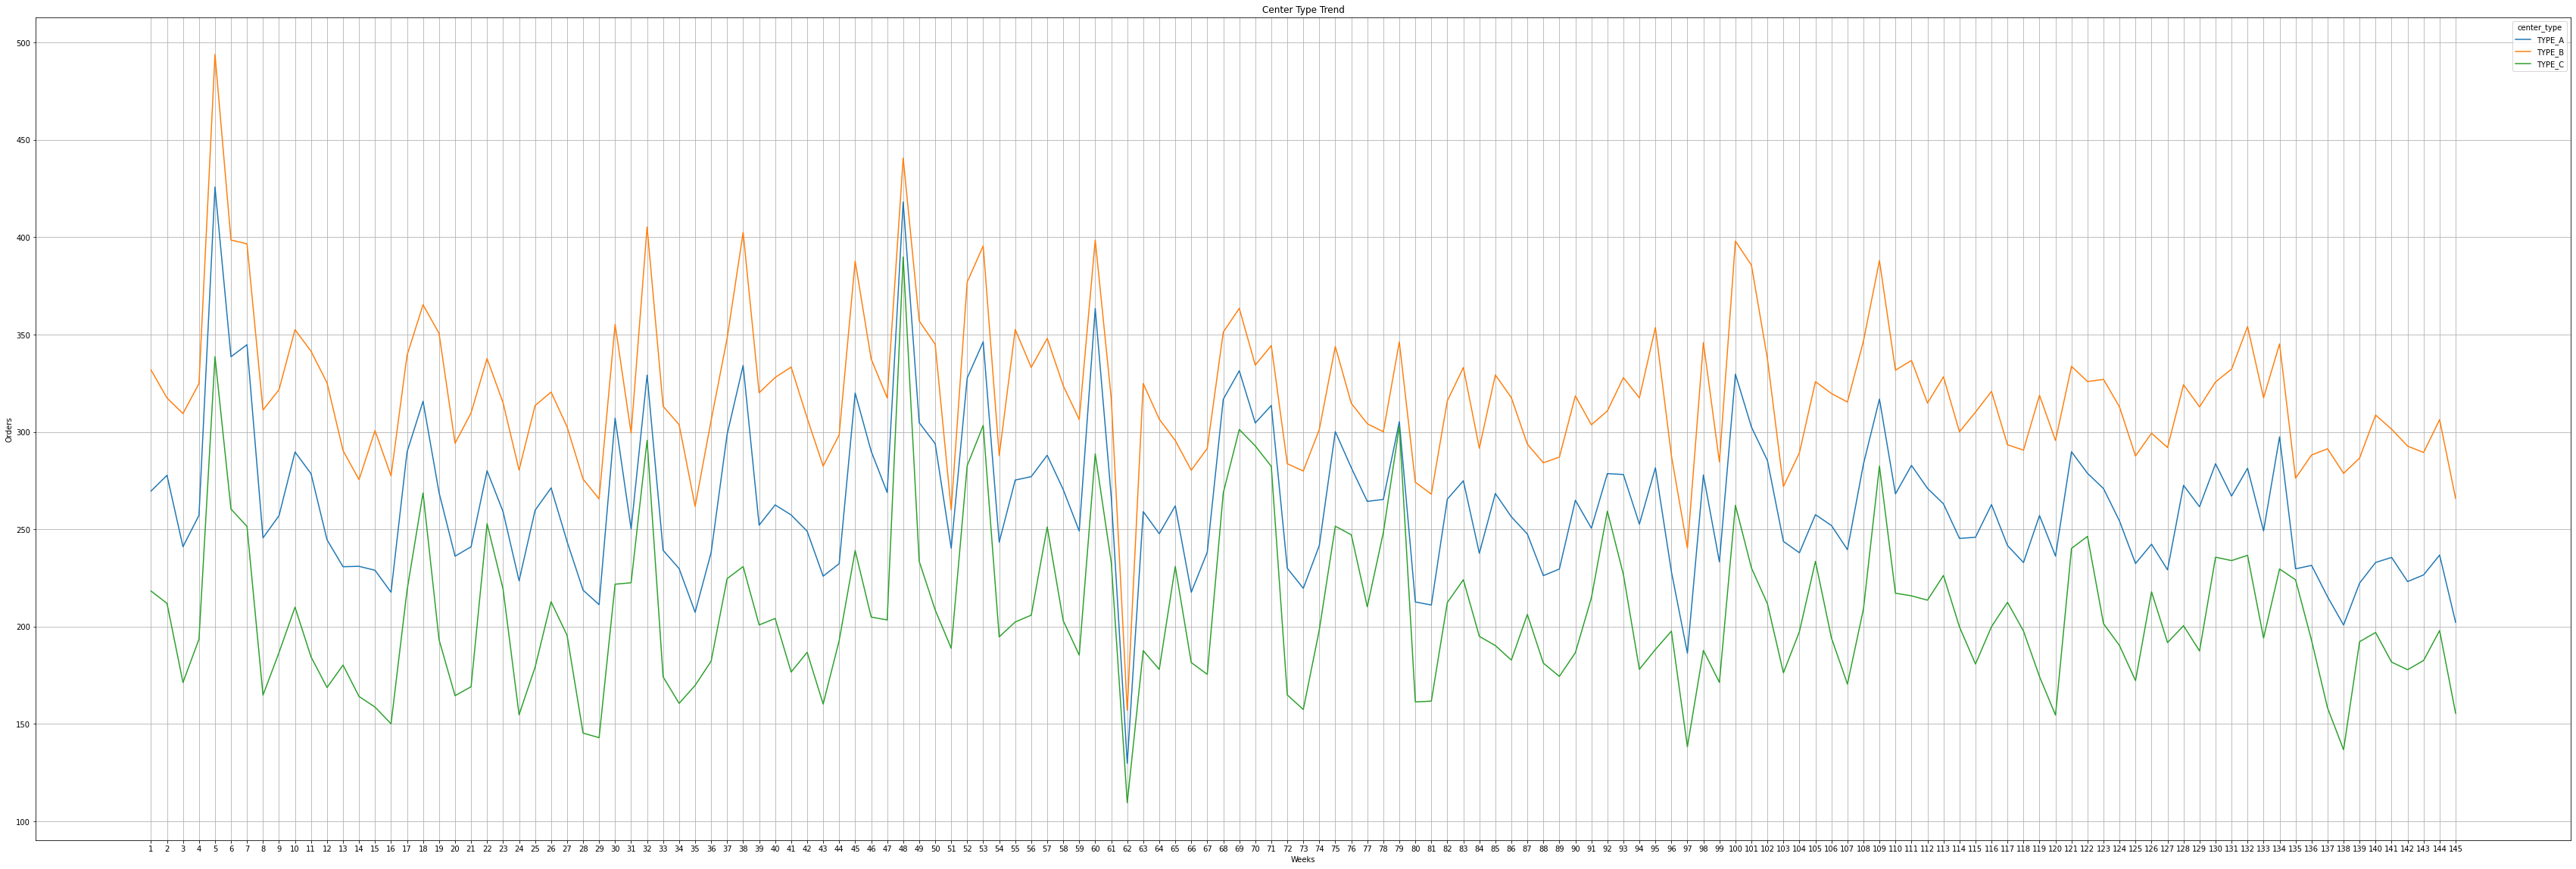

In [64]:
center_type_trend = master_data.pivot_table(index='week', columns='center_type', values='num_orders',aggfunc='mean')
center_type_trend.plot(figsize=(60,20))
plt.grid()
plt.xticks(stick)
plt.title("Center Type Trend")
plt.xlabel("Weeks")
plt.ylabel("Orders")
plt.show()

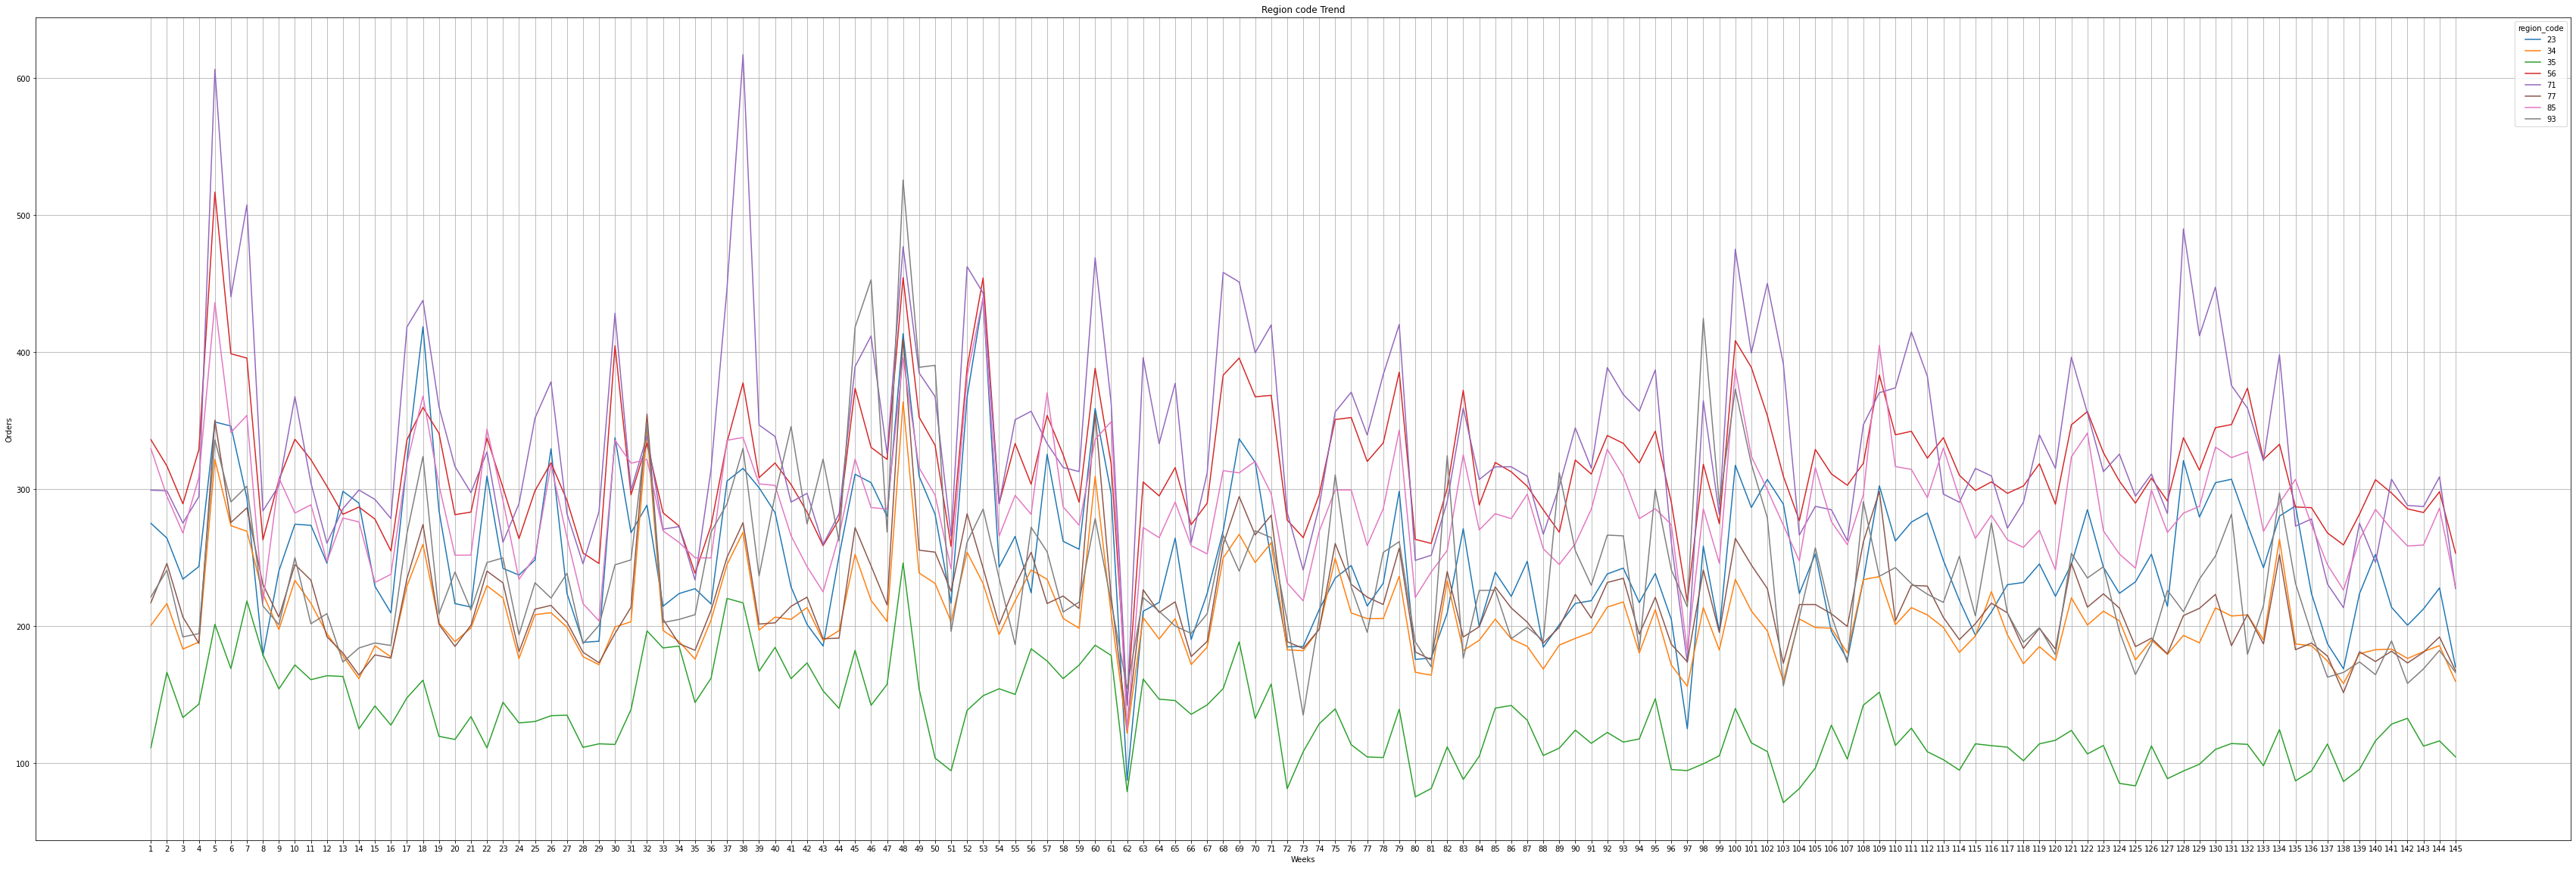

In [65]:
region_code_trend = master_data.pivot_table(index='week', columns='region_code', values='num_orders',aggfunc='mean')
region_code_trend.plot(figsize=(60,20))
plt.grid()
plt.xticks(stick)
plt.title("Region code Trend")
plt.xlabel("Weeks")
plt.ylabel("Orders")
plt.show()

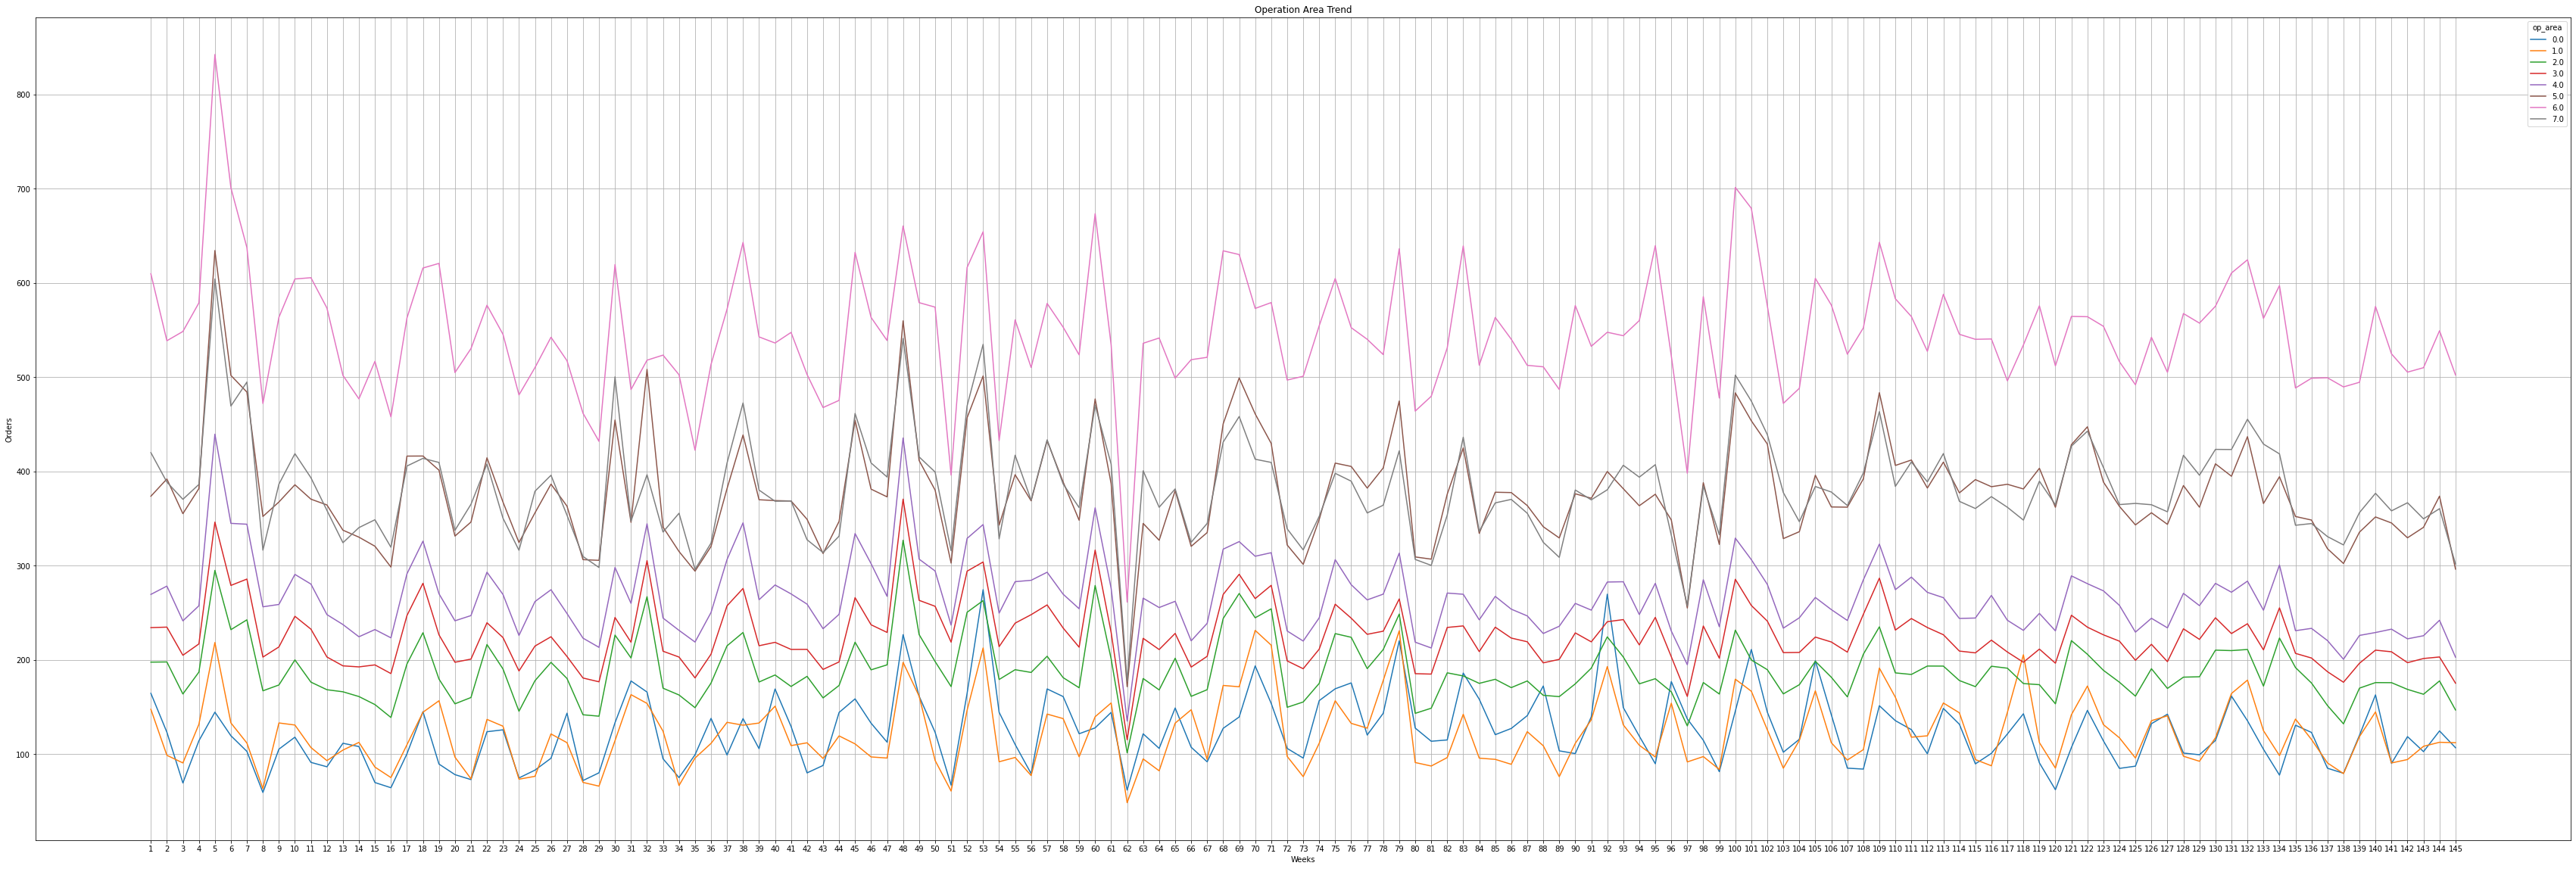

In [66]:
op_area_trend = master_data.copy()
op_area_trend['op_area'] = np.floor(op_area_trend['op_area'])
op_area_trend = op_area_trend.pivot_table(index='week', columns='op_area', values='num_orders',aggfunc='mean')
op_area_trend.plot(figsize=(60,20))
plt.grid()
plt.xticks(stick)
plt.title("Operation Area Trend")
plt.xlabel("Weeks")
plt.ylabel("Orders")
plt.show()

In [67]:
master_data['discount']=((master_data['base_price']-master_data['checkout_price'])*100/master_data['base_price'])
master_data[master_data['discount']<0]=0
master_data['discount']=round(master_data['discount'],2)

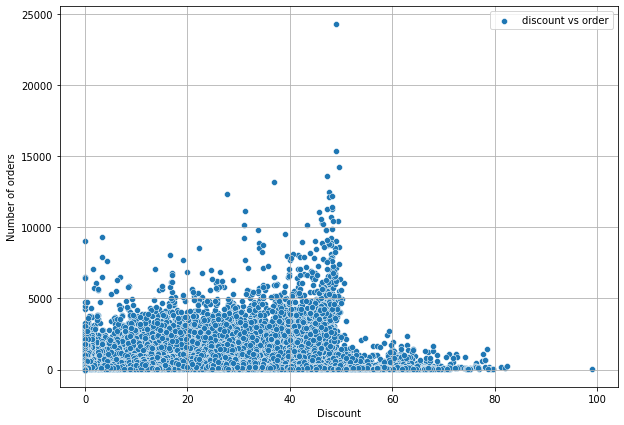

In [68]:
plt.figure(figsize=(10,7))
sns.scatterplot(x='discount',y='num_orders',data=master_data, label='discount vs order',ci=None)
plt.grid()
plt.xlabel("Discount")
plt.ylabel("Number of orders")
plt.show()

In [69]:
a=np.corrcoef(master_data['discount'],master_data['num_orders'])[0][1]
print("The correlation between discount and number of orders is %a" %a)

The correlation between discount and number of orders is 0.29405919237283107


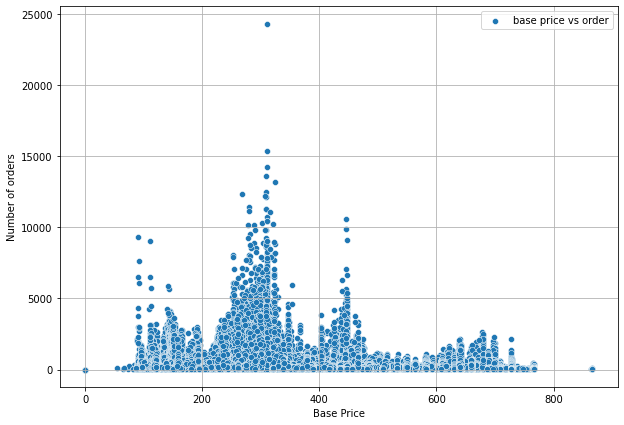

In [70]:
plt.figure(figsize=(10,7))
sns.scatterplot(x='base_price',y='num_orders',data=master_data, label='base price vs order',ci=None)
plt.grid()
plt.xlabel("Base Price")
plt.ylabel("Number of orders")
plt.show()

In [71]:
a=np.corrcoef(master_data['base_price'],master_data['num_orders'])[0][1]
print("The correlation between base price and number of orders is %a" %a)

The correlation between base price and number of orders is 0.1063727069741935


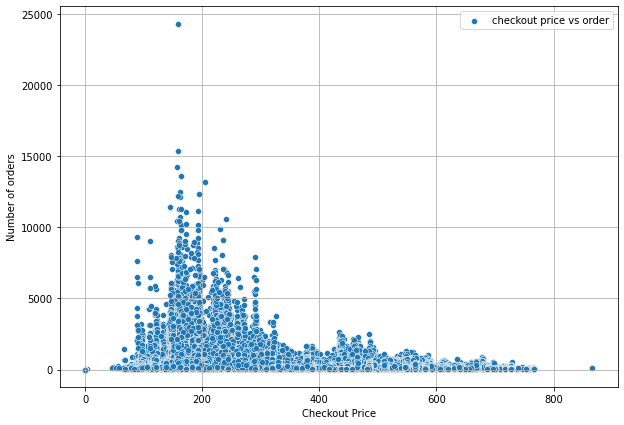

In [72]:
plt.figure(figsize=(10,7))
sns.scatterplot(x='checkout_price',y='num_orders',data=master_data, label='checkout price vs order',ci=None)
plt.grid()
plt.xlabel("Checkout Price")
plt.ylabel("Number of orders")
plt.show()

In [73]:
a=np.corrcoef(master_data['checkout_price'],master_data['num_orders'])[0][1]
print("The correlation between base price and number of orders is %a" %a)

The correlation between base price and number of orders is 0.05856218670557104


***There is very less correlation with price and number of orders, we hoped it could be negative implying price has a negatice effect on number of orders. But that is not the case and the correlation between discount and number of order is also significantly low.
So there are many other factors than price or discount that is affecting the demand viz number of orders in our problem.***

Further we have to test which variables have most correlation with number of orders, and as it is a time series data we will also try to fit an autoregression or other models..

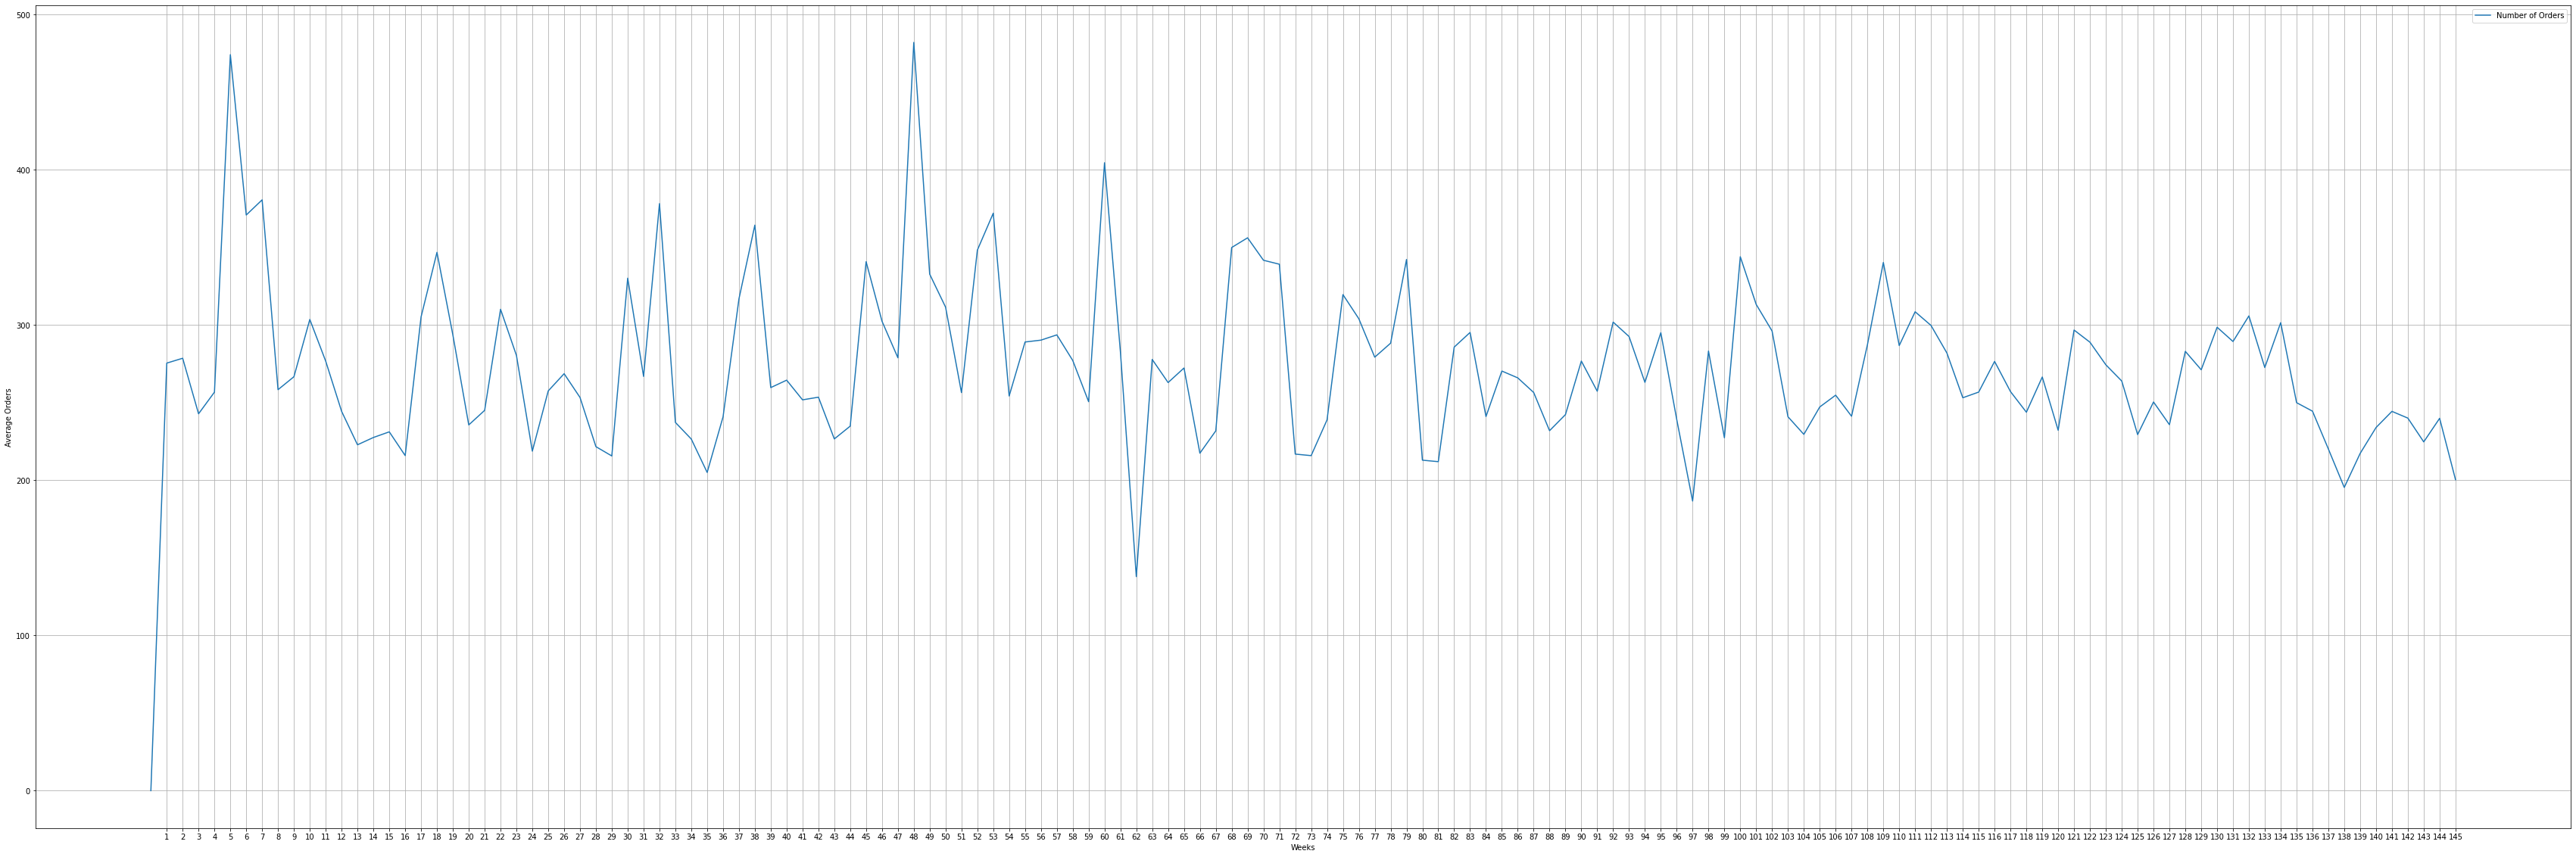

In [74]:
plt.figure(figsize=(60,20))
sns.lineplot(x='week',y='num_orders',data=master_data, label='Number of Orders',ci=None)
plt.grid()
plt.xlabel("Weeks")
plt.ylabel("Average Orders")
stick=np.arange(1,146,1)
plt.xticks(stick)
plt.show()

In [75]:
time_data=master_data['num_orders'].groupby(master_data['week']).sum()
time_data=pd.DataFrame(data=time_data)
time_data=time_data.drop(0)

In [76]:
time_data

num_orders
week            
1         620954
2         637758
3         539329
4         562342
5        1040444
...          ...
141       557943
142       548759
143       531492
144       578888
145       445216

[145 rows x 1 columns]

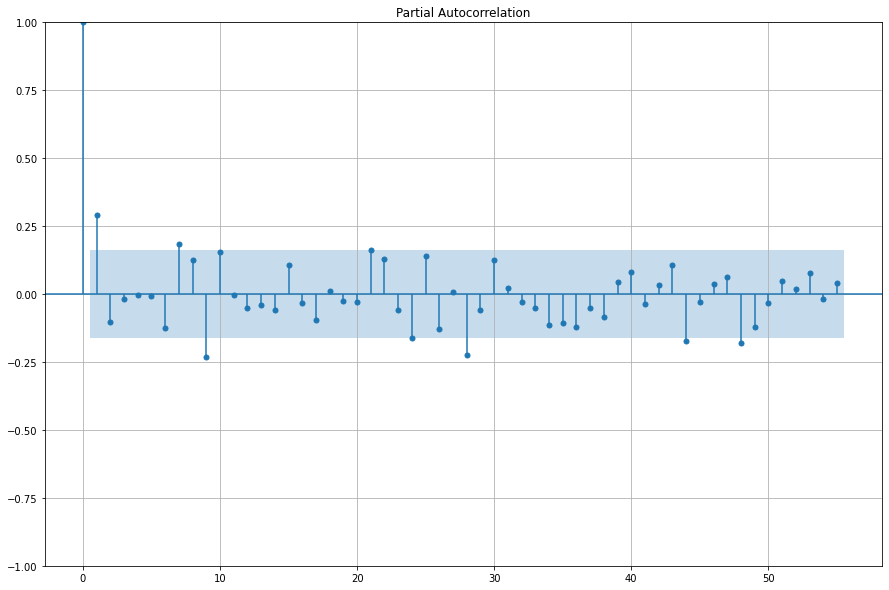

In [77]:
plt.rc("figure",figsize=(15,10))
sm.graphics.tsa.plot_pacf(time_data['num_orders'],alpha=0.05,lags=55,method='ols')
plt.grid()
plt.show()

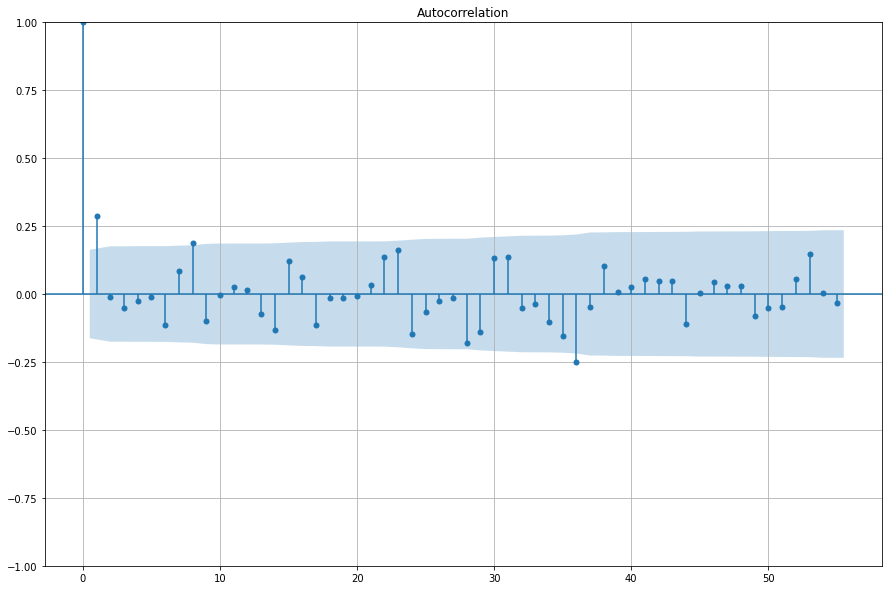

In [78]:
plt.rc("figure",figsize=(15,10))
sm.graphics.tsa.plot_acf(time_data['num_orders'],alpha=0.05,lags=55)
plt.grid()
plt.show()

In [79]:
master_reg=master_data.drop(['id',],axis=1)

In [80]:
corr=master_data.corr()

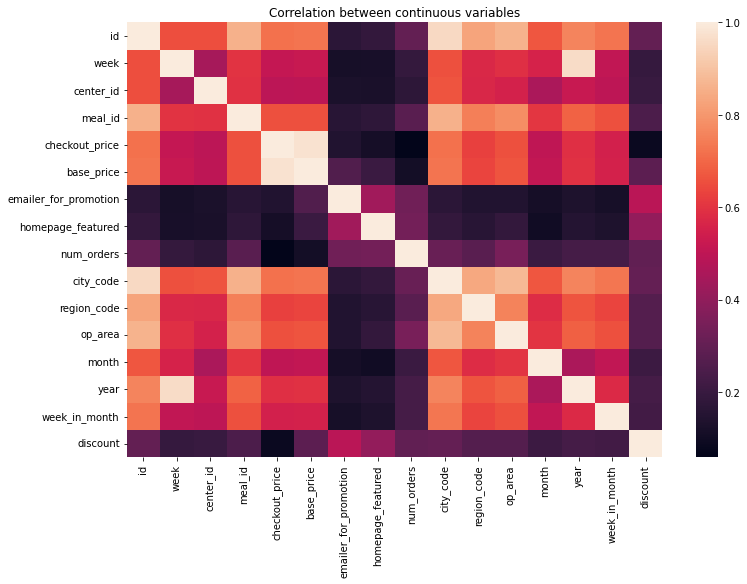

In [81]:
plt.rc("figure",figsize=(12,8))
sns.heatmap(corr)
plt.title("Correlation between continuous variables")
plt.show()

In [82]:
temp_df = master_data[["center_id", "cuisine", "category", "week", "num_orders"]]
temp_df.set_index(["center_id", "cuisine", "category", "week"]).loc[10, "Continental", "Beverages", 1]

temp_temp = temp_df.groupby(["center_id", "cuisine", "category", "week"]).agg('sum')

ts1=temp_temp.loc[10, "Continental", "Beverages"]

In [83]:
temp_temp.head()

num_orders
center_id cuisine     category  week            
0         0           0         0              0
10        Continental Beverages 1           1810
                                2           1496
                                3           1147
                                4           1257

*Moderately high correlation between homepage featured, emailer for promotion and number of orders, and negative correlation between base price, checkout price and number of orders.*

In [84]:
master_data['center_id'].value_counts()

0      116101
13       5305
52       5225
43       5192
67       5188
        ...  
139      3451
57       3372
162      3221
41       3088
91       2622
Name: center_id, Length: 78, dtype: int64

In [85]:
n=len(pd.unique(master_data['center_id']))

In [86]:
n

78

In [87]:
master_data['cuisine'].value_counts()

0              116101
Italian         91102
Thai            86760
Indian          84703
Continental     77882
Name: cuisine, dtype: int64

In [88]:
master_data['category'].value_counts()

0               116101
Beverages        93597
Pizza            26381
Rice Bowl        25148
Sandwich         24448
Other Snacks     22728
Desert           22226
Pasta            21663
Starters         20854
Seafood          20542
Salad            20301
Biryani          14738
Extras           11423
Soup              9293
Fish              7105
Name: category, dtype: int64

In [89]:
ts1

num_orders
week            
1           1810
2           1496
3           1147
4           1257
5            175
...          ...
141          297
142          391
143          338
144          150
145          419

[143 rows x 1 columns]

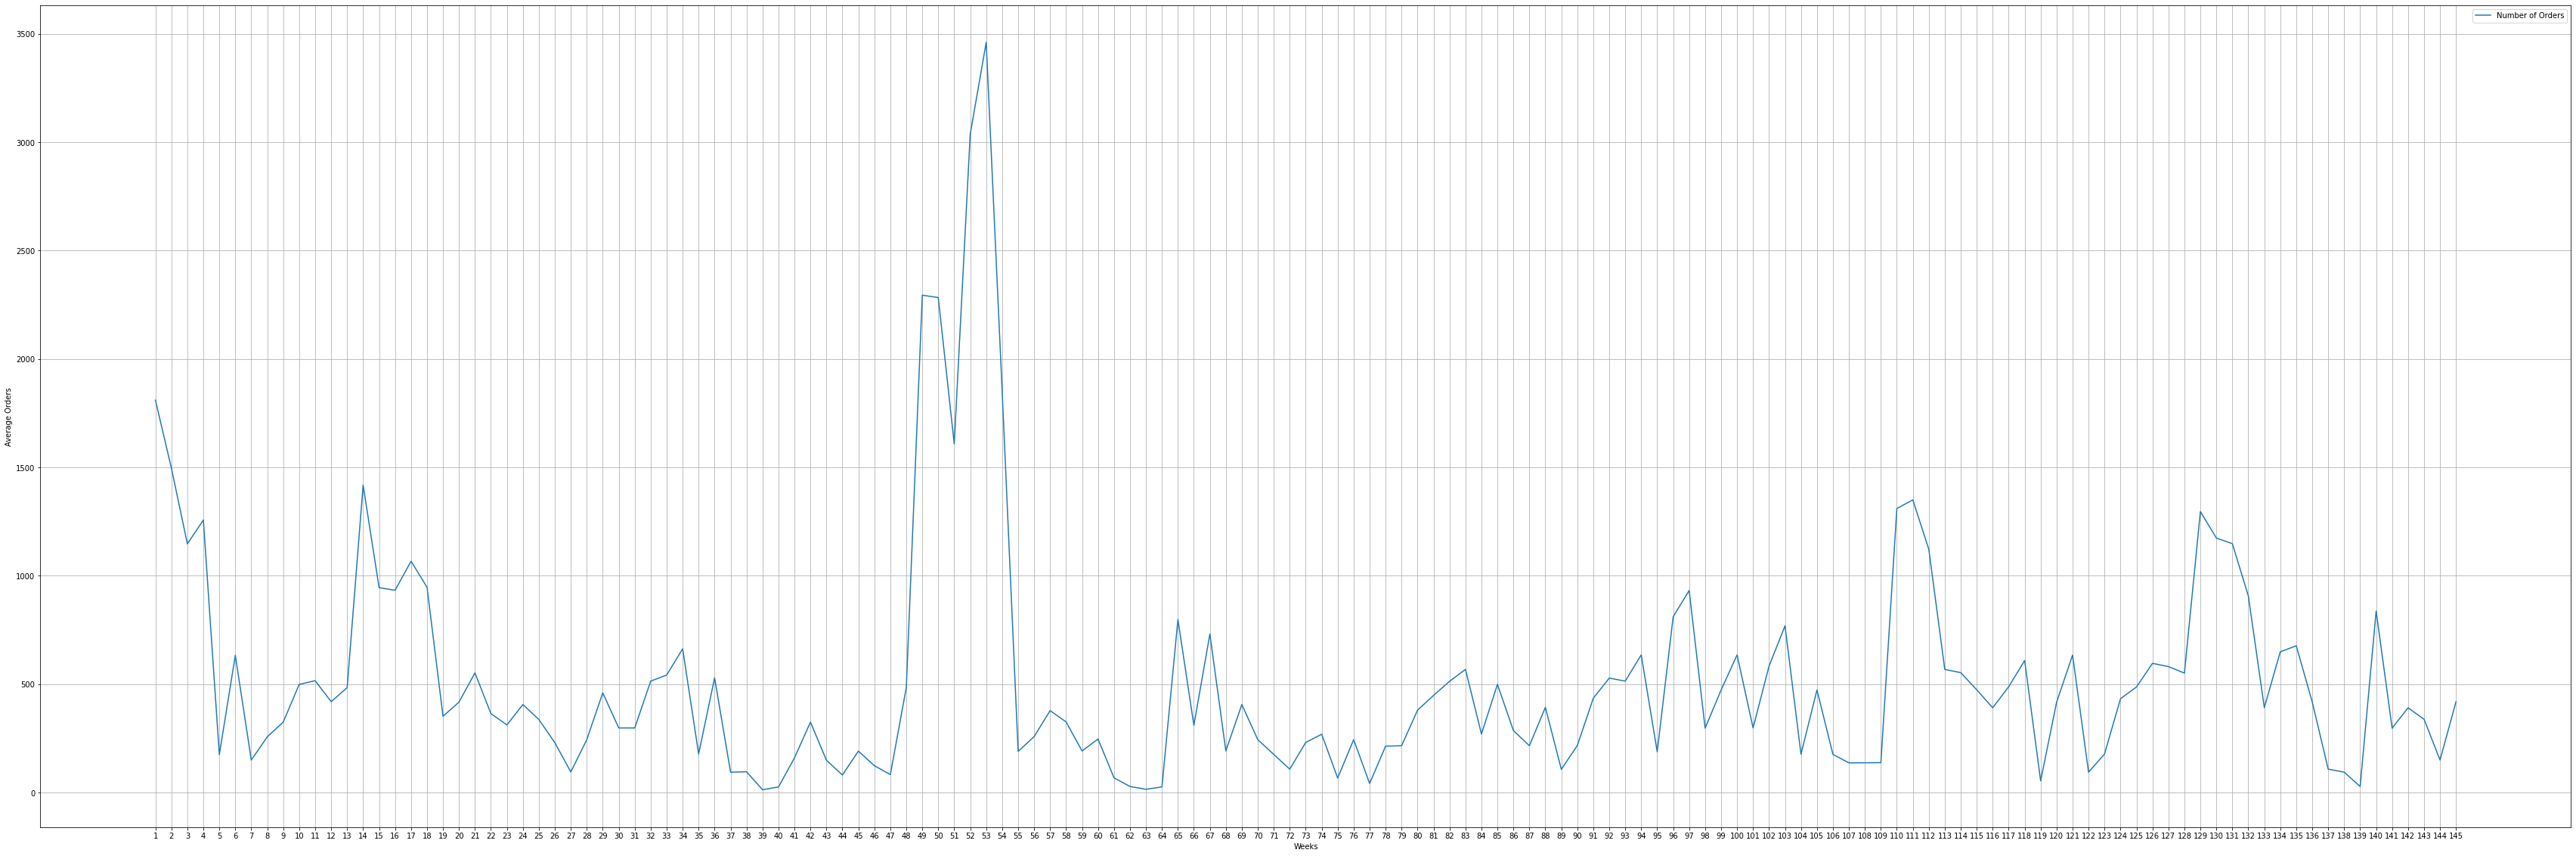

In [90]:
plt.figure(figsize=(60,20))
sns.lineplot(x='week',y='num_orders',data=ts1, label='Number of Orders',ci=None)
plt.grid()
plt.xlabel("Weeks")
plt.ylabel("Average Orders")
stick=np.arange(1,146,1)
plt.xticks(stick)
plt.show()

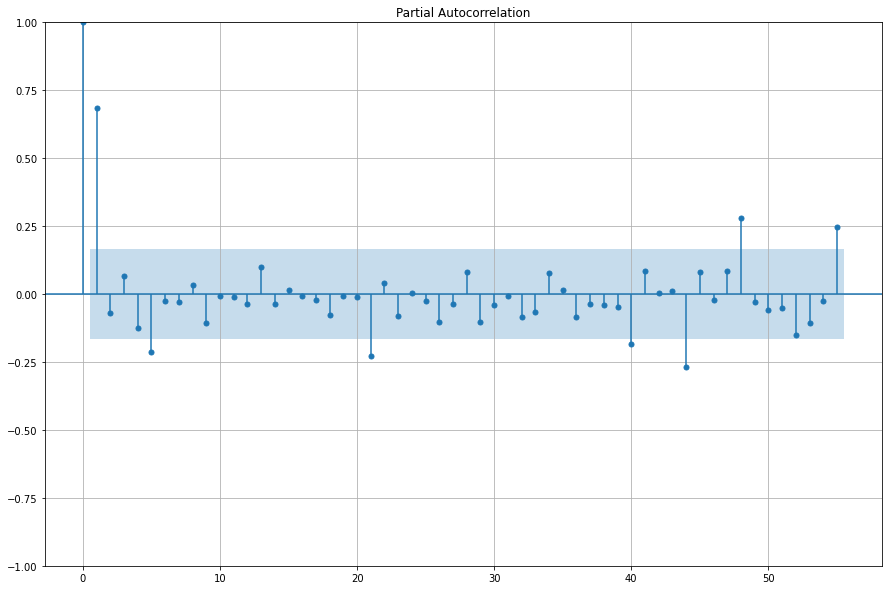

In [91]:
plt.rc("figure",figsize=(15,10))
sm.graphics.tsa.plot_pacf(ts1['num_orders'],alpha=0.05,lags=55,method='ols')
plt.grid()
plt.show()

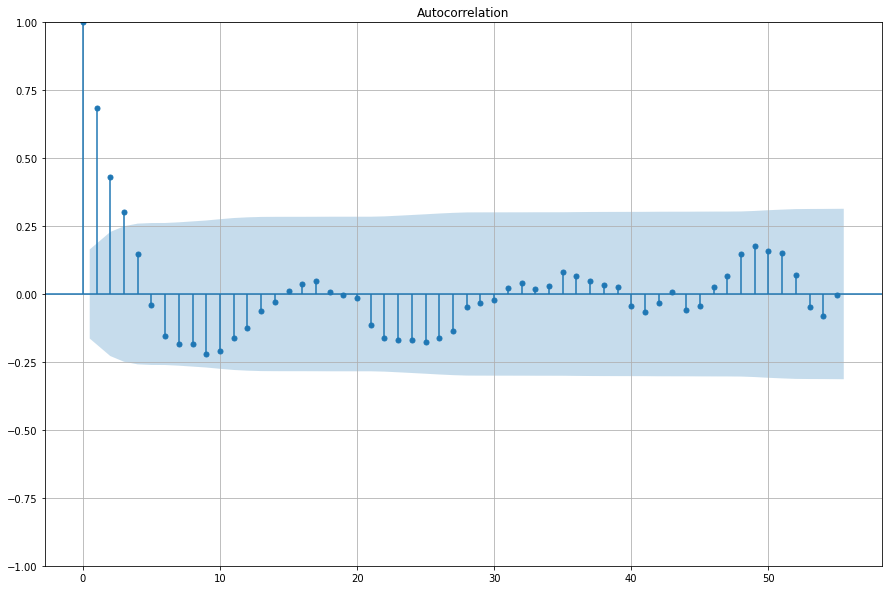

In [92]:
plt.rc("figure",figsize=(15,10))
sm.graphics.tsa.plot_acf(ts1['num_orders'],alpha=0.05,lags=55)
plt.grid()
plt.show()